<a href="https://colab.research.google.com/github/BrockH3/Intro_to_deep_Learning/blob/main/Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
#Problem 1
#Alexnet conv size of 5x5 with stride = 2
class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet,self).__init__()
    self.features = nn.Sequential(
    #Conv layer 1
      nn.Conv2d(3,50,kernel_size = 5,stride = 1, padding = 2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 3, stride = 2),
      #Conv layer 2
      nn.Conv2d(50, 100, kernel_size = 3, stride = 1, padding = 2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 3, stride = 2),
      #Conv layer 3
      nn.Conv2d(100, 256, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      #Conv layer 4
      nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      #Conv layer 5
      nn.Conv2d(256, 128, kernel_size = 3, stride = 1),
      nn.ReLU(),
      nn.Dropout(.5),
      nn.MaxPool2d(kernel_size = 3, stride = 2)
    )
    self.classifier = nn.Sequential(
      #linear layer 6
      nn.Linear(512,512),
      nn.ReLU(),
      nn.Dropout(.5),
      nn.Linear(512,256),
      nn.ReLU(),
      nn.Dropout(.5),
      nn.Linear(256,10)
    )
  def forward(self,x):
    x = self.features(x)
    x = torch.flatten(x,1)
    x = self.classifier(x)
    return x

In [3]:

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


100%|██████████| 170498071/170498071 [00:03<00:00, 48487653.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [8]:
#declare model
model = AlexNet()
net = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.001)

train_loss_list = []
val_loss_list = []
val_accuracy_list = []

In [9]:
#used train and val code from github to test with GPU instead of CPU
for epoch in range(10):
    running_loss = 0.0
    net.train()
    #train loop
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_list.append(running_loss / len(train_loader))

    # val loop
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(test_loader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)


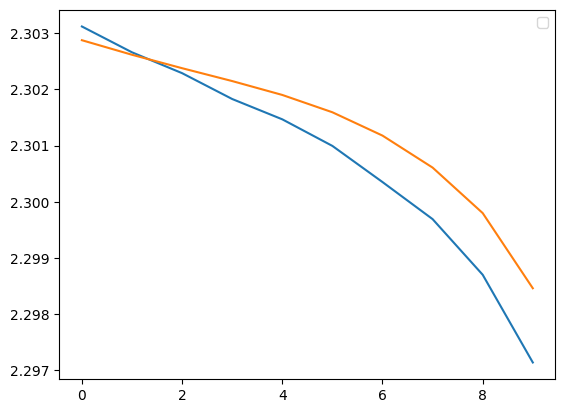

In [10]:
#plots

plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend()
plt.show()

In [11]:
print('training loss: ', train_loss_list[-1], 'val loss: ', val_loss_list[-1], 'val accuracy: ', val_accuracy_list[-1])

training loss:  2.2971363837949297 val loss:  2.298458631808004 val accuracy:  [10.0, 10.0, 10.0, 10.0, 10.0, 10.01, 10.99, 12.42, 13.12, 15.78]


In [18]:
#Problem 2
#build block
class block(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1):
    super(block, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
    self.bn1 = nn.BatchNorm2d(out_channels),
    self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
    self.bn2 = nn.BatchNorm2d(out_channels),
    self.relu = nn.ReLU()

  def forward(self,x):
    x =  self.conv1(x)
    x = self.bn1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    return x
class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size = 5, stride = 1, padding = 1),
    self.bn1 = nn.BatchNorm2d(64),
    self.relu = nn.ReLU(),
    self.mp = nn.MaxPool2d(kernel_size = 2, stride = 1),

    self.layer1 = self._make_layer(64, 64, stride = 1),
    self.layer2 = self._make_layer(64, 128, stride = 1),
    self.layer3 = self._make_layer(128, 256, stride = 2),
    self.layer4 = self._make_layer(256, 256, stride = 2),

    self.flatten = nn.Flatten(1)
    self.linear = nn.Linear(256,10)
  def _make_layer(self, in_channels, out_channels, stride):
    return nn.Sequential(
        block(in_channels, out_channels, stride)
    )
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.mp(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.mp(x)
    x = self.flatten(x)
    x = self.linear(x)
    return x

In [24]:
#declare model
model = ResNet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.001)

train_loss_list = []
val_loss_list = []
val_accuracy_list = []

[]


In [26]:
for epoch in range(10):
    running_loss = 0.0
    net.train()
    #train loop
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_list.append(running_loss / len(train_loader))

    # val loop
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(test_loader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)


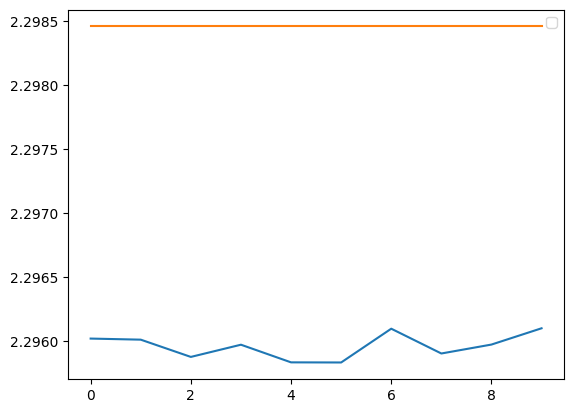

In [29]:
#plots

plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend()
plt.show()

In [30]:
print('training loss: ', train_loss_list[-1], 'val loss: ', val_loss_list[-1], 'val accuracy: ', val_accuracy_list[-1])

training loss:  2.2960994826321106 val loss:  2.298458631808004 val accuracy:  15.78
